In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
%matplotlib inline

## Business Understanding

The goal of this project is to get as much information as possible about used car sales from the data available. We have looked for any actionable guidance hidden in the data that might help a buyer optimize their experience and result. 

The dataset was helpfully scraped from Craiglist in January 2020 by Austin Reese and posted to kaggle here: https://www.kaggle.com/austinreese/craigslist-carstrucks-data

## Data Understanding

The data is a raw, messy dataset compiled of web scrapings of Craigslist so let's dig in.

Style note: Chris Albon, in his book Machine Learning with Python Cookbook, recommends to avoid using inplace=True and to treat each dataframe as an immutable object. Since he has so much experience in production DS systems, I'm attempting to adhere to his recommendations in this notebook and hopefully develop good habits.

In [2]:
filename = "vehicles.csv"
all_v = pd.read_csv(filename)
all_v.head(3)

,Unnamed: 0,id,url,region,region_url,price,year,manufacturer,model,condition,...,drive,size,type,paint_color,image_url,description,state,lat,long,posting_date
0,0,7240372487,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,35990,2010.0,chevrolet,corvette grand sport,good,...,rwd,NaN,other,NaN,https://images.craigslist.org/00N0N_ipkbHVZYf4...,Carvana is the safer way to buy a car During t...,al,32.590000,-85.480000,2020-12-02T08:11:30-0600
1,1,7240309422,https://auburn.craigslist.org/cto/d/auburn-201...,auburn,https://auburn.craigslist.org,7500,2014.0,hyundai,sonata,excellent,...,fwd,NaN,sedan,NaN,https://images.craigslist.org/00s0s_gBHYmJ5o7y...,I'll move to another city and try to sell my c...,al,32.547500,-85.468200,2020-12-02T02:11:50-0600
2,2,7240224296,https://auburn.craigslist.org/cto/d/auburn-200...,auburn,https://auburn.craigslist.org,4900,2006.0,bmw,x3 3.0i,good,...,NaN,NaN,SUV,blue,https://images.craigslist.org/00B0B_5zgEGWPOrt...,Clean 2006 BMW X3 3.0I. Beautiful and rare Bl...,al,32.616807,-85.464149,2020-12-01T19:50:41-0600


In [3]:
# get a sense for how messy the raw data is
all_v.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458213 entries, 0 to 458212
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    458213 non-null  int64  
 1   id            458213 non-null  int64  
 2   url           458213 non-null  object 
 3   region        458213 non-null  object 
 4   region_url    458213 non-null  object 
 5   price         458213 non-null  int64  
 6   year          457163 non-null  float64
 7   manufacturer  439993 non-null  object 
 8   model         453367 non-null  object 
 9   condition     265273 non-null  object 
 10  cylinders     287073 non-null  object 
 11  fuel          454976 non-null  object 
 12  odometer      402910 non-null  float64
 13  title_status  455636 non-null  object 
 14  transmission  455771 non-null  object 
 15  VIN           270664 non-null  object 
 16  drive         324025 non-null  object 
 17  size          136865 non-null  object 
 18  type

In [4]:
all_v.describe()

,Unnamed: 0,id,price,year,odometer,lat,long
count,458213.000000,4.582130e+05,4.582130e+05,457163.000000,4.029100e+05,450765.000000,450765.000000
mean,229106.000000,7.235233e+09,4.042093e+04,2010.746067,1.016698e+05,38.531925,-94.375824
std,132274.843786,4.594362e+06,8.194599e+06,8.868136,3.228623e+06,5.857378,18.076225
min,0.000000,7.208550e+09,0.000000e+00,1900.000000,0.000000e+00,-82.607549,-164.091797
25%,114553.000000,7.231953e+09,4.900000e+03,2008.000000,4.087700e+04,34.600000,-110.890427
50%,229106.000000,7.236409e+09,1.099500e+04,2013.000000,8.764100e+04,39.244500,-88.314889
75%,343659.000000,7.239321e+09,2.149500e+04,2016.000000,1.340000e+05,42.484503,-81.015022
max,458212.000000,7.241019e+09,3.615215e+09,2021.000000,2.043756e+09,82.049255,150.898969


In [5]:
# how many unique instances for each variable?
def get_value_diversity(df):
    '''
    Understand the diversity of a dataframe by getting the value counts for each column.
    Parameters: dataframe
    Returns: new dataframe with value counts for each column
    '''
    val_cts = pd.DataFrame(columns = ['Name', 'Length'])
    for c in list(df.columns):
        l = len(df[c].value_counts().index)
        val_cts = val_cts.append({'Name': c, 'Length' : l}, ignore_index=True)
    return val_cts
        
total_val_cts = get_value_diversity(all_v)
total_val_cts.head(len(all_v))

,Name,Length
0,Unnamed: 0,458213
1,id,458213
2,url,458213
3,region,405
4,region_url,413
5,price,16924
6,year,110
7,manufacturer,43
8,model,31520
9,condition,6


## Prepare the data for analysis

## Which columns hold useful information?
When you are interested in trends or predictions, data that is too specific, ie. has a very small instance to dataset ratio, is often uninformative.  For example, there are over 30k models in a 450k dataset.  For comparison, there are just 13 types of vehicles in the 450k dataset. The information we will have on each Type will have a much richer set of observations from which to draw. Even if we just keep the top 50 models, it quickly drops to a few hundred examples per model. (We'll get back to the specific model column discussion later.)

Other columns we can assume from common-sense will be unhelpful are the url of the post, the region_url, the VIN, the transmission, the image_url, and the latitude/longitude coordinates (we have geographic info at state and region levels). We'll drop manufacturer because we're keeping model for now. We'll drop Unnamed but keep the id as an potentially useful index.

In [6]:
use_cols = ['id', 'price', 'year', 'model', 'condition', 'cylinders', 'fuel', 'odometer',
       'drive', 'size', 'type', 'title_status', 'paint_color', 'description', 'state', 'posting_date']
useless_cols = ['Unnamed: 0', 'url', 'region_url', 'VIN', 'image_url', 'region', 'lat', 'long',
                'transmission', 'manufacturer', ]
# assert that we have accounted for all columns
assert len(list(all_v.columns)) == len(use_cols + useless_cols)
# remove the useless columns
useful = all_v.drop(useless_cols, axis=1)
useful.set_index('id')
useful.head(3)

,id,price,year,model,condition,cylinders,fuel,odometer,title_status,drive,size,type,paint_color,description,state,posting_date
0,7240372487,35990,2010.0,corvette grand sport,good,8 cylinders,gas,32742.0,clean,rwd,NaN,other,NaN,Carvana is the safer way to buy a car During t...,al,2020-12-02T08:11:30-0600
1,7240309422,7500,2014.0,sonata,excellent,4 cylinders,gas,93600.0,clean,fwd,NaN,sedan,NaN,I'll move to another city and try to sell my c...,al,2020-12-02T02:11:50-0600
2,7240224296,4900,2006.0,x3 3.0i,good,6 cylinders,gas,87046.0,clean,NaN,NaN,SUV,blue,Clean 2006 BMW X3 3.0I. Beautiful and rare Bl...,al,2020-12-01T19:50:41-0600


### Missing data
A few columns are missing a significant percentage of their values. 
* The size of a vehicle can be inferred by its type so we can drop the Size column in favor of the better-populated Type. Although Type is also missing values, they are few enough for us to drop the rows and still have a good quantity.
* Condition is only populated for about 50% of the items. Since one of the questions we'd like to answer is the strength of the relationship between condition and price, we should not impute these values. Only the rows with valid entries are useful for us so we will drop the others. 
* Paint_color is another attribute of investigative interest so it's worth some time investment to get it right. We will do a basic search of the Description to see if we can pull the color from there.
* The number of Cylinders could be useful information. The most likely method to be accurate is to fill cyclinders based on Type but that would still lead to misinformation on underpowered SUVs or overpowered Compacts. So, in order to avoid possibly misleading noise, we'll drop cylinders.
* Drive has similar issues to Cylinders in terms of potentially misleading imputed values.  However, it is of more investigative interest since one of our questions is whether 4WD has any more of a relationship to price in one region vs the other. Let's drop the missing rows. 
* Just to tidy up, we'll drop the few rows missing Description.

In [7]:
# deal with the missing data
missing_cols = ['size', 'cylinders']
more_useful = useful.drop(missing_cols, axis=1)
missing_rows = ['odometer','type','condition','drive','description']
cleaner = more_useful.dropna(subset=missing_rows, axis=0)
cleaner.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179730 entries, 0 to 458211
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            179730 non-null  int64  
 1   price         179730 non-null  int64  
 2   year          179730 non-null  float64
 3   model         178786 non-null  object 
 4   condition     179730 non-null  object 
 5   fuel          179730 non-null  object 
 6   odometer      179730 non-null  float64
 7   title_status  179730 non-null  object 
 8   drive         179730 non-null  object 
 9   type          179730 non-null  object 
 10  paint_color   159585 non-null  object 
 11  description   179730 non-null  object 
 12  state         179730 non-null  object 
 13  posting_date  179730 non-null  object 
dtypes: float64(2), int64(2), object(10)
memory usage: 20.6+ MB


### Clip outliers
I want to focus on helping the typical buyer so let's remove some confounding variables.




In [8]:
# Eliminate any title_status other than 'clean' and the salvage titles hiding in condition.
clean_title = cleaner.loc[(cleaner['title_status'] == 'clean') & (cleaner['condition'].ne('salvage'))]
#Avoid too old or classic cars or year data entry errors.
no_classics = clean_title.loc[clean_title['year'] > 2000]
# Avoid luxury cars or price data entry errors
majority_prices = no_classics.loc[no_classics['price'] < 100000]
# now that the title status is only a single value, it doesn't add anything to the analysis, drop the col
majority = majority_prices.drop(['title_status'], axis=1)
majority.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160610 entries, 0 to 458211
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            160610 non-null  int64  
 1   price         160610 non-null  int64  
 2   year          160610 non-null  float64
 3   model         160044 non-null  object 
 4   condition     160610 non-null  object 
 5   fuel          160610 non-null  object 
 6   odometer      160610 non-null  float64
 7   drive         160610 non-null  object 
 8   type          160610 non-null  object 
 9   paint_color   141725 non-null  object 
 10  description   160610 non-null  object 
 11  state         160610 non-null  object 
 12  posting_date  160610 non-null  object 
dtypes: float64(2), int64(2), object(9)
memory usage: 17.2+ MB


### Location
I tried several variations of location features, and think that a broader geo grouping adds value.

In [9]:
west = ['ca','or','wa','id','mt','co', 'az', 'nv','nm','ak','hi','wy','ut']
east = ['ny', 'pa', 'ma','nj', 'va','dc','wv','ct','vt','md','ri','nh','me','de']
mid = ['mi','oh','wi','il','ia','in', 'mn','ks','mo','sd','nd','ne']
south = ['fl','tx', 'nc', 'tn','al','ms','ok', 'ga','sc','ky','ar','la']
geo_labels = {1: "West", 2: "Mid", 3: "South", 4: "East"}
#validate that all 50 states & DC are represented
assert len(west)+len(east)+len(mid)+len(south) == 51

majority['geo'] = 0
majority.loc[(majority['state'].isin(west)), 'geo'] = 1
majority.loc[(majority['state'].isin(mid)), 'geo'] = 2
majority.loc[(majority['state'].isin(south)), 'geo'] = 3
majority.loc[(majority['state'].isin(east)), 'geo'] = 4
majority['geo'].value_counts()

3    42846
2    41112
1    39200
4    37452
Name: geo, dtype: int64

### Time
Timestamps are too specific to provide actionable info for our buyer, so let's convert that to day of week.

In [10]:
# Day 0 is Monday
day_labels = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
# timezones often complicate calculations so make it consistent with utc=True
majority['posting_date'] = pd.to_datetime(majority['posting_date'], utc=True)
majority['posting_day'] = pd.DatetimeIndex(majority['posting_date']).dayofweek
majority.drop(['posting_date'], axis=1, inplace=True)

### Description
The freeform description text could be used for multiple purposes:
* use length to see if whether brief or verbose descriptions do better
* derive other column's missing data, such as grabbing a color for paint_color
* run it through an NLP model to determine sentiment analysis

In the interests of time, I'll only do the first two. Once we've pulled the information we need, we can drop the description column.

In [11]:
## Get the length of the description * clip outliers
len_col = majority['description'].apply(lambda row: len(row))
majority = majority.assign(**{'desc_len':len_col.values})
majority = majority.loc[majority['desc_len'] < 8000]

In [12]:
# Get the paint_color from the description when included in that text

colors_to_search = ['white','black','silver','grey','blue','red', 'orange','brown','green']
found_ctr = 0
for index, row in majority.iterrows():    
    if pd.isnull(row['paint_color']):
        for w in colors_to_search:
            if w in row['description']:
                found_ctr += 1
                # make sure the update the original dataframe with df.at
                # row[col_name] = value will only update the working copy
                majority.at[index, 'paint_color'] = w
print("We were able to find colors for "+str(found_ctr)+" cars.")
# drop any remaining rows missing paint_color
majority.dropna(subset=['paint_color'], axis=0, inplace=True)

We were able to find colors for 15976 cars.


In [13]:
# Remove the description column now that we have extracted what we could from it
# This dataframe is ready for analysis, although we may do more transformations before predictive modeling
cleanest = majority.drop(['description'], axis=1)

In [14]:
cleanest.describe()

,id,price,year,odometer,geo,posting_day,desc_len
count,1.529790e+05,152979.000000,152979.000000,1.529790e+05,152979.000000,152979.000000,152979.000000
mean,7.235187e+09,15402.380856,2012.051020,1.094254e+05,2.508658,2.652122,2326.785833
std,4.616551e+06,12311.983352,4.770434,5.226228e+06,1.095229,1.859392,1943.395151
min,7.221912e+09,0.000000,2001.000000,0.000000e+00,1.000000,0.000000,1.000000
25%,7.231834e+09,5995.000000,2008.000000,4.054900e+04,2.000000,1.000000,462.000000
50%,7.236328e+09,11999.000000,2013.000000,8.960000e+04,3.000000,2.000000,1744.000000
75%,7.239366e+09,22000.000000,2016.000000,1.360000e+05,3.000000,4.000000,4175.000000
max,7.241019e+09,99999.000000,2021.000000,2.043756e+09,4.000000,6.000000,7999.000000


In [15]:

clean_div = get_value_diversity(cleanest)
clean_div.head(len(clean_div))

,Name,Length
0,id,152979
1,price,7008
2,year,21
3,model,13347
4,condition,5
5,fuel,5
6,odometer,50049
7,drive,3
8,type,13
9,paint_color,12


## Data Analysis
Now that the raw data has been processed, the dataframe is ready to be analyzed.

           posting_day    perc
Wednesday        31596  20.654
Tuesday          28035  18.326
Monday           21151  13.826
Saturday         20363  13.311
Friday           19831  12.963
Thursday         19555  12.783
Sunday           12448   8.137


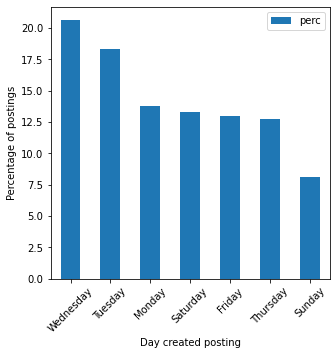

In [16]:
# Which day has the most fresh postings?
# show the distribution of posting days
dd = pd.DataFrame(cleanest['posting_day'].value_counts())
dd = dd.rename(index=day_labels)
dd['perc'] = dd.div(dd.sum(axis=0), axis=1).mul(100).round(3)
print(dd)
dd_perc = dd.drop(['posting_day'], axis=1)

fig, ax = plt.subplots(figsize=(5,5))
dd_perc.plot.bar(rot=0, ax=ax);
ax.set_xlabel("Day created posting")
ax.set_ylabel("Percentage of postings")
plt.xticks(rotation=45)
fig.savefig('All_posting_days_5x5.png')

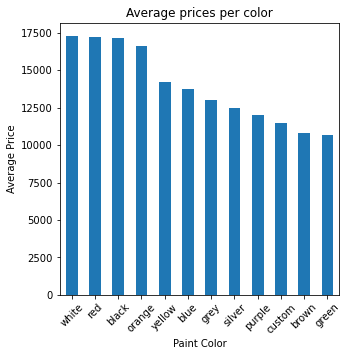

In [17]:
# is there a relationship between paint color and price?
paints = cleanest.groupby('paint_color')['price'].mean().sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(5,5))
paints.plot.bar(rot=0.3, ax=ax);
ax.set_title('Average prices per color')
ax.set_xlabel('Paint Color')
plt.xticks(rotation=45)
ax.set_ylabel('Average Price')
fig.savefig('All_color_price_5x5.png')

### The Model feature
The vehicle model is a complicated variable.  At 13k values, it is too diverse to use for predictive modeling and there are many data entry errors because it is a free text field.  However, there may be some analytic value. We'll keep it for now and do a quick data entry cleanup on the top two models.


In [18]:
model_conv = {'model': {'f-150': 'f150', '1500': 'silverado 1500', 'silverado': 'silverado 1500'}}
cleanest = cleanest.replace(model_conv)

17265.41


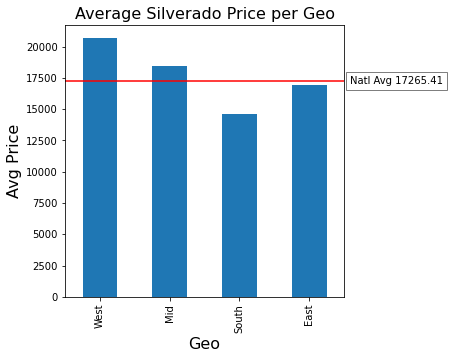

In [19]:
silverado = cleanest.loc[cleanest['model'] == 'silverado 1500']
silverado_avg_price = silverado['price'].mean().round(2)
silverado_geo_prices = silverado.groupby('geo')['price'].mean()

geo_labels = {1: "West", 2: "Mid", 3: "South", 4: "East"}

silverado_geo_prices = silverado_geo_prices.rename(index=geo_labels)

print(silverado_avg_price)
silverado_geo_prices.head(5)

# create a bar chart of the average prices per region
fig, ax = plt.subplots(figsize=(5,5))
silverado_geo_prices.plot(kind='bar', ax=ax)
ax.set_title('Average Silverado Price per Geo', fontsize=16)
ax.set_xlabel('Geo', fontsize=16)
ax.set_ylabel('Avg Price', fontsize=16)
# create a horizontal line showing the national average for comparison
ax.axhline(silverado_avg_price, color="red")
ax.text(1.02, silverado_avg_price, "Natl Avg "+str(silverado_avg_price), va='center', ha="left", bbox=dict(facecolor="w",alpha=0.5),
        transform=ax.get_yaxis_transform())
fig.savefig('Silverado_price_geo_5x5.png')
#show plot
plt.show()


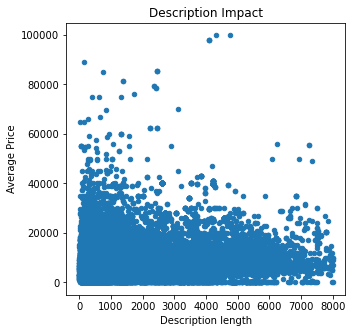

In [20]:
# See if there is any value in longer descriptions with a scatterplot of description length and price
#desc_val = cleanest[['desc_len', 'price']] #no pattern for total set
#desc_val = silverado[['desc_len', 'price']] #no pattern for most popular model
#geo_test = cleanest.loc[cleanest['geo'] == 4] # no pattern for any geo
year_test = cleanest.loc[cleanest['year'] < 2010] # no pattern for older cars
desc_val = year_test[['desc_len', 'price']]

fig, ax = plt.subplots(figsize=(5,5))
desc_val.plot.scatter(x='desc_len', y='price', ax=ax)
ax.set_title('Description Impact')
ax.set_xlabel('Description length')
ax.set_ylabel('Average Price')
fig.savefig('Desc_len_older_cars_5x5.png')
plt.show()

## Data Modeling

In [21]:
# Before predictive modeling, we need to convert categorical values to numeric
cat_vars = cleanest.select_dtypes(include=['object'])
num_vars = cleanest.select_dtypes(include=['int64','float64'])
cat_val_cts = get_value_diversity(cat_vars)
cat_val_cts.head(len(cat_vars.columns))

,Name,Length
0,model,13344
1,condition,5
2,fuel,5
3,drive,3
4,type,13
5,paint_color,12
6,state,51


In [22]:
def one_hots(df, cols, prefixes):
    '''
    Convert categorical values to one-hot encodings.
    Parameters: df = dataframe,
        cols = array of categorical columns to be converted
        prefixes = array of strings to be prepended to column names of one-hot cols
    Returns: model_data = new dataframe with numerical columns representing one-hot encodings
        model_cols = a list of all columns in the new dataframe
    '''
    model_data = pd.get_dummies(df, columns=cols, prefix=prefixes)
    model_cols = list(model_data.columns)
    return model_data, model_cols

In [23]:
#defaults
test_size=0.30
random_state=17

# get model datasets
def get_train_test_data(model_data, target_col, test_size=0.30, random_state=17):
    '''
    Split dataset into training and testing datasets for model training
    Parameters: model_data = dataframe,
        target_col = string representing the y-value to be predicted
        test-size = float represeting percentage of data to be held back for testing, default to 30%
        random_state = int representing the random seed for reproducibility, default to 17
    Returns: X-train = set of training columns and rows
        X_test = set of testing columns and rows
        y_train = target column to be learned in training
        y_test = target column to be tested and scored against predictions
    '''
    X = model_data.drop([target_col], axis=1)
    y = model_data[target_col]
    #Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test



In [24]:
def train_and_score_model(model, md='model desc'):
    '''
    Convert categorical values to one-hot encodings.
    Parameters: model = scikit-learn model object,
        md = string describing the model being trained, default to model-desc
    Returns: metrics_dict = dictionary holding the results of the training and testing runs
    '''
    # Train
    model.fit(X_train, y_train)

    #Predict 
    y_train_preds = model.predict(X_train)
    y_test_preds = model.predict(X_test)


    #Score the model
    train_r2_score = r2_score(y_train, y_train_preds)
    test_r2_score = r2_score(y_test, y_test_preds)
    train_mse = mean_squared_error(y_train, y_train_preds)
    test_mse = mean_squared_error(y_test, y_test_preds)
    train_mae = mean_absolute_error(y_train, y_train_preds)
    test_mae = mean_absolute_error(y_test, y_test_preds)
    print(md)
    print("R2 train: %.3f, test: %.3f" % (train_r2_score, test_r2_score))
    print("MSE train: %.3f, test: %.3f" % (train_mse, test_mse))
    print("MAE train: %.3f, test: %.3f" % (train_mae, test_mae))
    metrics_dict = {'trainR2' : train_r2_score, 'testR2': test_r2_score,
                   'trainMSE': train_mse, 'testMSE': test_mse,
                   'trainMAE' : train_mae, 'testMAE': test_mae}
    return metrics_dict

### Try modeling with minimal feature selection
The only feature engineering we'll do here is to drop the noisiest variables - model has 13k and state has 51.

In [25]:
national = cleanest.drop(['model', 'state'], axis=1)
national, national_cols = one_hots(national, cols=['condition','fuel','drive','type','paint_color'],
                                  prefixes=['c','f','d','t','p'])

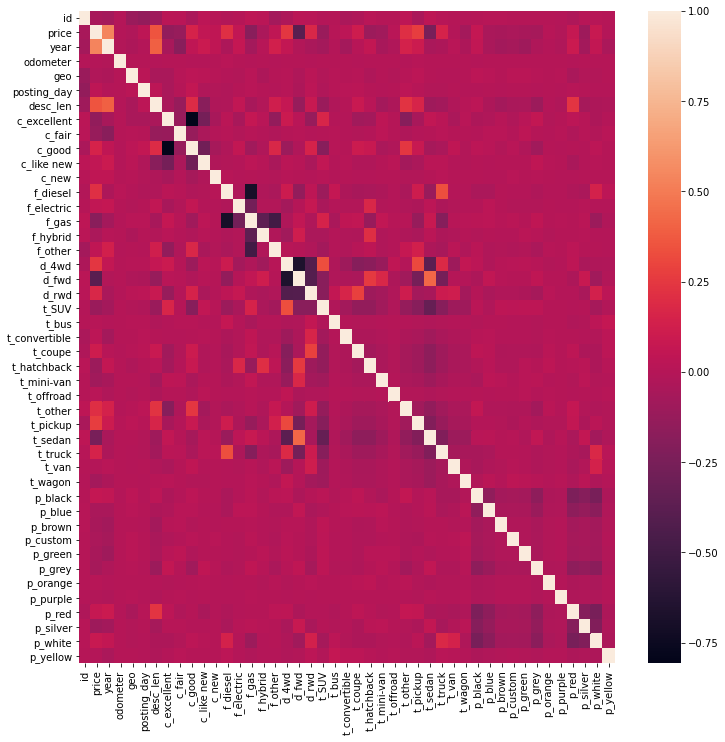

In [26]:
national_corrs = national.corr()
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(national_corrs)
plt.show()

In [27]:
national_data = national.select_dtypes(include=['uint8','int64','float64'])
X_train, X_test, y_train, y_test = get_train_test_data(national_data, target_col='price')

In [28]:
# Baseline linear regression model
# Create the model
lm= LinearRegression(normalize=True) 
lm_results = train_and_score_model(lm, 'LinearRegression')
lmdf = pd.DataFrame([lm_results])
lmdf.head()



LinearRegression
R2 train: 0.545, test: 0.534
MSE train: 68857821.863, test: 70980497.700
MAE train: 5636.410, test: 5697.269


,trainR2,testR2,trainMSE,testMSE,trainMAE,testMAE
0,0.544902,0.533751,6.885782e+07,7.098050e+07,5636.410188,5697.26888


In [29]:
# Decision Tree
dt = DecisionTreeRegressor(criterion='mae', max_depth=4) 
dt_results = train_and_score_model(dt, 'DecisionTreeRegressor')
dtdf = pd.DataFrame([dt_results])

DecisionTreeRegressor
R2 train: 0.534, test: 0.520
MSE train: 70571360.359, test: 73108193.164
MAE train: 5473.288, test: 5540.128


In [30]:
# Random Forest
# n_jobs=-1 to use all processors

rf = RandomForestRegressor(n_estimators=600, criterion='mse', random_state=random_state, n_jobs=-1)
rf_results = train_and_score_model(rf, 'RandomForestRegressor')
rfdf = pd.DataFrame([rf_results])

RandomForestRegressor
R2 train: 0.977, test: 0.824
MSE train: 3450797.587, test: 26864414.580
MAE train: 935.827, test: 2570.691


### Try modeling by geo
By focusing on a geographic region, we can include the state feature to see if finer location data improves the model.

In [31]:
west_geo = cleanest.loc[cleanest['geo'] == 1]
west_geo.drop(['model'], axis=1, inplace=True)
west_geo, west_geo_cols = one_hots(west_geo, cols=['condition','fuel','drive','type','paint_color', 'state'],
                                  prefixes=['c','f','d','t','p', 's'])

/Users/lquera/opt/anaconda3/envs/tfp36/lib/python3.6/site-packages/pandas/core/frame.py:3994: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [32]:
west_geo_corrs = west_geo.corr()

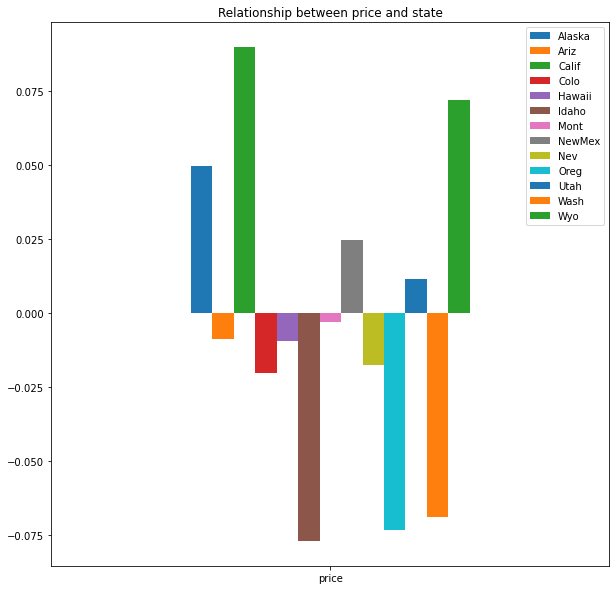

In [33]:
# prep the data for analyzing price and state correlations
state_labels = {'s_ak': 'Alaska', 's_az': 'Ariz', 's_ca': 'Calif', 's_co': 'Colo', 's_hi': 'Hawaii', 
                's_id': 'Idaho', 's_mt': 'Mont', 's_nm': 'NewMex', 's_nv': 'Nev', 's_or': 'Oreg',
               's_ut': 'Utah', 's_wa': 'Wash', 's_wy': 'Wyo'}
drop_cols = ['id', 'year', 'odometer', 'geo', 'posting_day', 'desc_len', 
             'c_excellent', 'c_fair', 'c_good', 'c_like new', 'c_new', 
             'f_diesel', 'f_electric', 'f_gas', 'f_hybrid', 'f_other', 
             'd_4wd', 'd_fwd', 'd_rwd', 
             't_SUV', 't_bus', 't_convertible', 't_coupe', 't_hatchback', 't_mini-van', 't_offroad', 
             't_other', 't_pickup', 't_sedan', 't_truck', 't_van', 't_wagon', 
             'p_black', 'p_blue', 'p_brown', 'p_custom', 'p_green', 'p_grey', 'p_orange', 'p_purple', 
             'p_red', 'p_silver', 'p_white', 'p_yellow']
state_corrs = west_geo_corrs.drop(drop_cols, axis=1)
state_price = state_corrs.loc[state_corrs['price'] == 1.0]
state_plot = state_price.drop(['price'], axis=1)
state_plot = state_plot.rename(columns=state_labels)

# visualize the relationship
fig, ax = plt.subplots(figsize=(10,10))
state_plot.plot.bar(rot=0, ax=ax);
ax.set_title('Relationship between price and state')
ax.set_label('Correlation of state and price')
fig.savefig('West_state_price_10x10.png')

In [34]:
west_data = west_geo.select_dtypes(include=['uint8','int64','float64'])
X_train, X_test, y_train, y_test = get_train_test_data(west_data, target_col='price')

In [46]:
# Baseline linear regression model
# Create the model
lm= LinearRegression(normalize=True) 
lm_results = train_and_score_model(lm, 'LinearRegressionWest')
lmdf_west = pd.DataFrame([lm_results])


LinearRegressionWest
R2 train: 0.403, test: 0.410
MSE train: 86620129.066, test: 92347673.306
MAE train: 6653.825, test: 6998.420


In [36]:
# Decision Tree
dt = DecisionTreeRegressor(criterion='mae', max_depth=4) 
dt_results = train_and_score_model(dt, 'DecisionTreeRegressorWest')
dtdf_west = pd.DataFrame([dt_results])

DecisionTreeRegressorWest
R2 train: 0.444, test: 0.429
MSE train: 84058324.894, test: 88515976.361
MAE train: 5720.371, test: 5843.832


In [37]:
# Random Forest
# n_jobs=-1 to use all processors

rf = RandomForestRegressor(n_estimators=600, criterion='mse', random_state=random_state, n_jobs=-1)
rf_results = train_and_score_model(rf, 'RandomForestRegressorWest')
rfdf_west = pd.DataFrame([rf_results])

RandomForestRegressorWest
R2 train: 0.971, test: 0.779
MSE train: 4458119.128, test: 34247261.947
MAE train: 1147.487, test: 3191.018


### Results
Surprisingly, finer location did not improve

### Test whether using a single vehicle model gets any better predictive results
This is a very small dataset for training but it's worth a try to see if removing that variability helps or hurts our chances of good predictions.  Sometimes it is better to have a few good small models than one larger mediocre one.

In [38]:
silverado.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3788 entries, 529 to 458018
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           3788 non-null   int64  
 1   price        3788 non-null   int64  
 2   year         3788 non-null   float64
 3   model        3788 non-null   object 
 4   condition    3788 non-null   object 
 5   fuel         3788 non-null   object 
 6   odometer     3788 non-null   float64
 7   drive        3788 non-null   object 
 8   type         3788 non-null   object 
 9   paint_color  3788 non-null   object 
 10  state        3788 non-null   object 
 11  geo          3788 non-null   int64  
 12  posting_day  3788 non-null   int64  
 13  desc_len     3788 non-null   int64  
dtypes: float64(2), int64(5), object(7)
memory usage: 443.9+ KB


In [39]:
silverado_model = silverado.drop(['model', 'type','state'], axis=1)
silverado_model, silverado_model_cols = one_hots(silverado_model, cols=['condition','fuel','drive','paint_color'],
                                  prefixes=['c','f','d','p'])

In [40]:
silverado_corrs = silverado_model.corr()
#silverado_corrs.head(len(silverado_corrs))

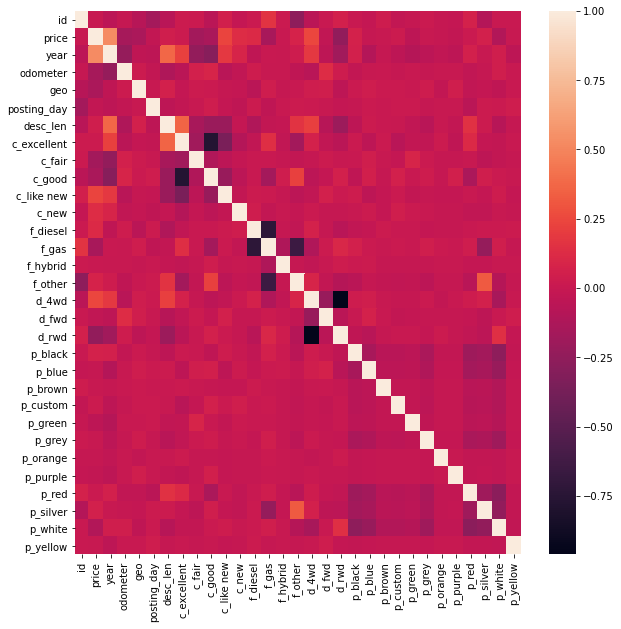

In [41]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(silverado_corrs)
plt.show()

In [42]:
silverado_data = silverado_model.select_dtypes(include=['uint8','int64','float64'])
X_train, X_test, y_train, y_test = get_train_test_data(silverado_data, target_col='price')

In [43]:
# Baseline linear regression model
# Create the model
lm= LinearRegression(normalize=True) 
lm_results = train_and_score_model(lm, 'LinearRegressionSilverado')
lmdf_silv = pd.DataFrame([lm_results])
lmdf.head()



LinearRegressionSilverado
R2 train: 0.403, test: 0.410
MSE train: 86620129.066, test: 92347673.306
MAE train: 6653.825, test: 6998.420


,trainR2,testR2,trainMSE,testMSE,trainMAE,testMAE
0,0.544902,0.533751,6.885782e+07,7.098050e+07,5636.410188,5697.26888


In [44]:
# Decision Tree
dt = DecisionTreeRegressor(criterion='mae', max_depth=4) 
dt_results = train_and_score_model(dt, 'DecisionTreeRegressorSilverado')
dtdf_silv = pd.DataFrame([dt_results])

DecisionTreeRegressorSilverado
R2 train: 0.338, test: 0.409
MSE train: 96010345.157, test: 92549698.785
MAE train: 5712.828, test: 5741.440


In [45]:
# Random Forest
# n_jobs=-1 to use all processors

rf = RandomForestRegressor(n_estimators=600, criterion='mse', random_state=random_state, n_jobs=-1)
rf_results = train_and_score_model(rf, 'RandomForestRegressorSilverado')
rfdf_silv = pd.DataFrame([rf_results])

RandomForestRegressorSilverado
R2 train: 0.960, test: 0.721
MSE train: 5752650.406, test: 43759451.728
MAE train: 1385.027, test: 3759.407


## Evaluate Results

With the most powerful model, the Random Forest Regressor, on the largest dataset, National, the Mean Absolute Error of $2570 is equivalent to about 6% of the national average price.  However, the significant difference between training and test results indicate that the model is probably overfit. 

The comparison models on more focused datasets did worse.  On a single vehicle model, the Silverado 1500 with an average price of $17,250, we would only be able to predict with a mean absolute error that is equivalent to 22% of the average price. The associated correlation heatmap gives a good indication that there aren't a lot of predictive indicators available for the training model to learn from. 

## Act upon Results
Now that we’ve looked at the data to discover what it could tell us, there is an actionable strategy to get the best possible deal when buying a used car on Craigslist.

*Start your search on a Wednesday or earlier.

*Look at uncommon colors for the best deals

*Check into other locations to see if the price difference makes traveling worthwhile

*Don’t get distracted by fancier listings and stay focused on your priority attributes

*Don’t just assume the asking price is based on good data. It might not be correlated with your priority attributes. Spend some time looking around at comparable models and be prepared to negotiate based on your own findings.
 